#### Nathan 2021 PBMC abridged QC

**Objective**: Run QC steps without normalisation/UMAP for Nathan 2021 data

- **Developed by**: Mairi McClean
- **Affiliation**: Institute of Computational Biology, Helmholtz Zentrum Munich
- **v230306**

### Load required modules

In [2]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

#### Log file and figure output settings

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')


-----
anndata     0.8.0
scanpy      1.9.2
-----
PIL                 8.2.0
anyio               NA
appnope             0.1.3
arrow               1.2.3
asttokens           NA
attr                22.2.0
babel               2.12.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
executing           1.2.0
fastjsonschema      NA
fqdn                NA
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph              0.10.4
ipykernel           6.21.2
ipython_genutils    0.2.0
isoduration         NA
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
json5               NA
jsonpointer         2.3
jsonschema          4.17.3
jupyter_events

### Read datasets

In [4]:
adata = sc.read_h5ad('/Volumes/LaCie/data_lake/Mairi_example/INBOX/sc_downloads/nathan_2021_from_carlos/Lung_TB_T_Cells_CITESEQ_RNA.h5ad')
adata

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

### Make names unique

In [5]:
adata.var_names_make_unique()
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

In [6]:
sample_object.shape


(500089, 33538)

In [7]:
sample_object.var

(33538, 0)

In [8]:
sample_object.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

### Top 20 scatterplot

In [ ]:
# highest fraction of counts per cell

sc.pl.highest_expr_genes(sample_object, n_top=20)

### Initial filtering

- By gene

In [13]:
sc.pp.filter_cells(sample_object, min_genes = 200)
print(sample_object.n_obs, sample_object.n_vars)

500089 33538


- By cell

In [ ]:
sc.pp.filter_genes(sample_object, min_cells = 3)
sample_object.shape

### QC metrics

In [15]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var["hb"] = sample_object.var_names.str.contains(("^HB[^(P)]"))
sample_object.var

,gene_ids,mt,ribo
gene_name,,,
MIR1302-2HG,MIR1302-2HG,False,False
FAM138A,FAM138A,False,False
OR4F5,OR4F5,False,False
AL627309.1,AL627309.1,False,False
AL627309.3,AL627309.3,False,False
...,...,...,...
AC233755.2,AC233755.2,False,False
AC233755.1,AC233755.1,False,False
AC240274.1,AC240274.1,False,False


- Check values present in new columns

In [ ]:
sample_object.var['mt'].value_counts()

In [ ]:
sample_object.var['ribo'].value_counts()

In [ ]:
sample_object.var['hb'].value_counts()

In [23]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

### Visualise QC metrics

In [ ]:
p1 = sns.displot(sample_object.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(sample_object, "pct_counts_mt")
p3 = sc.pl.scatter(sample_object, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

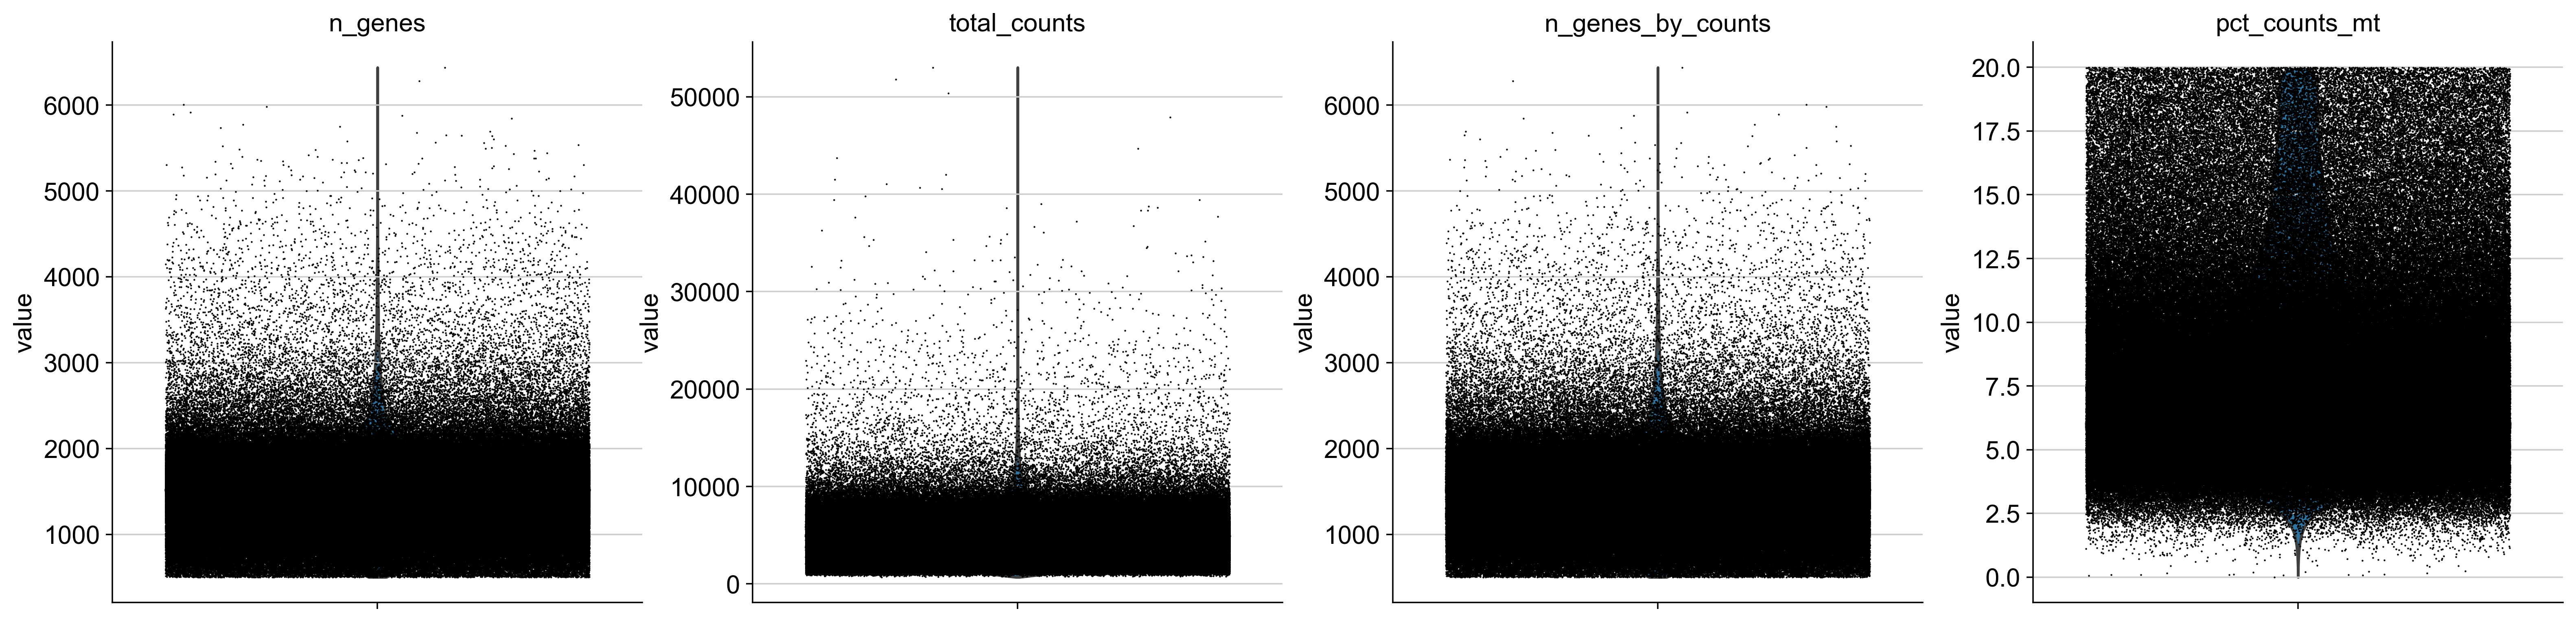

In [27]:
sc.pl.violin(sample_object, ['n_genes', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

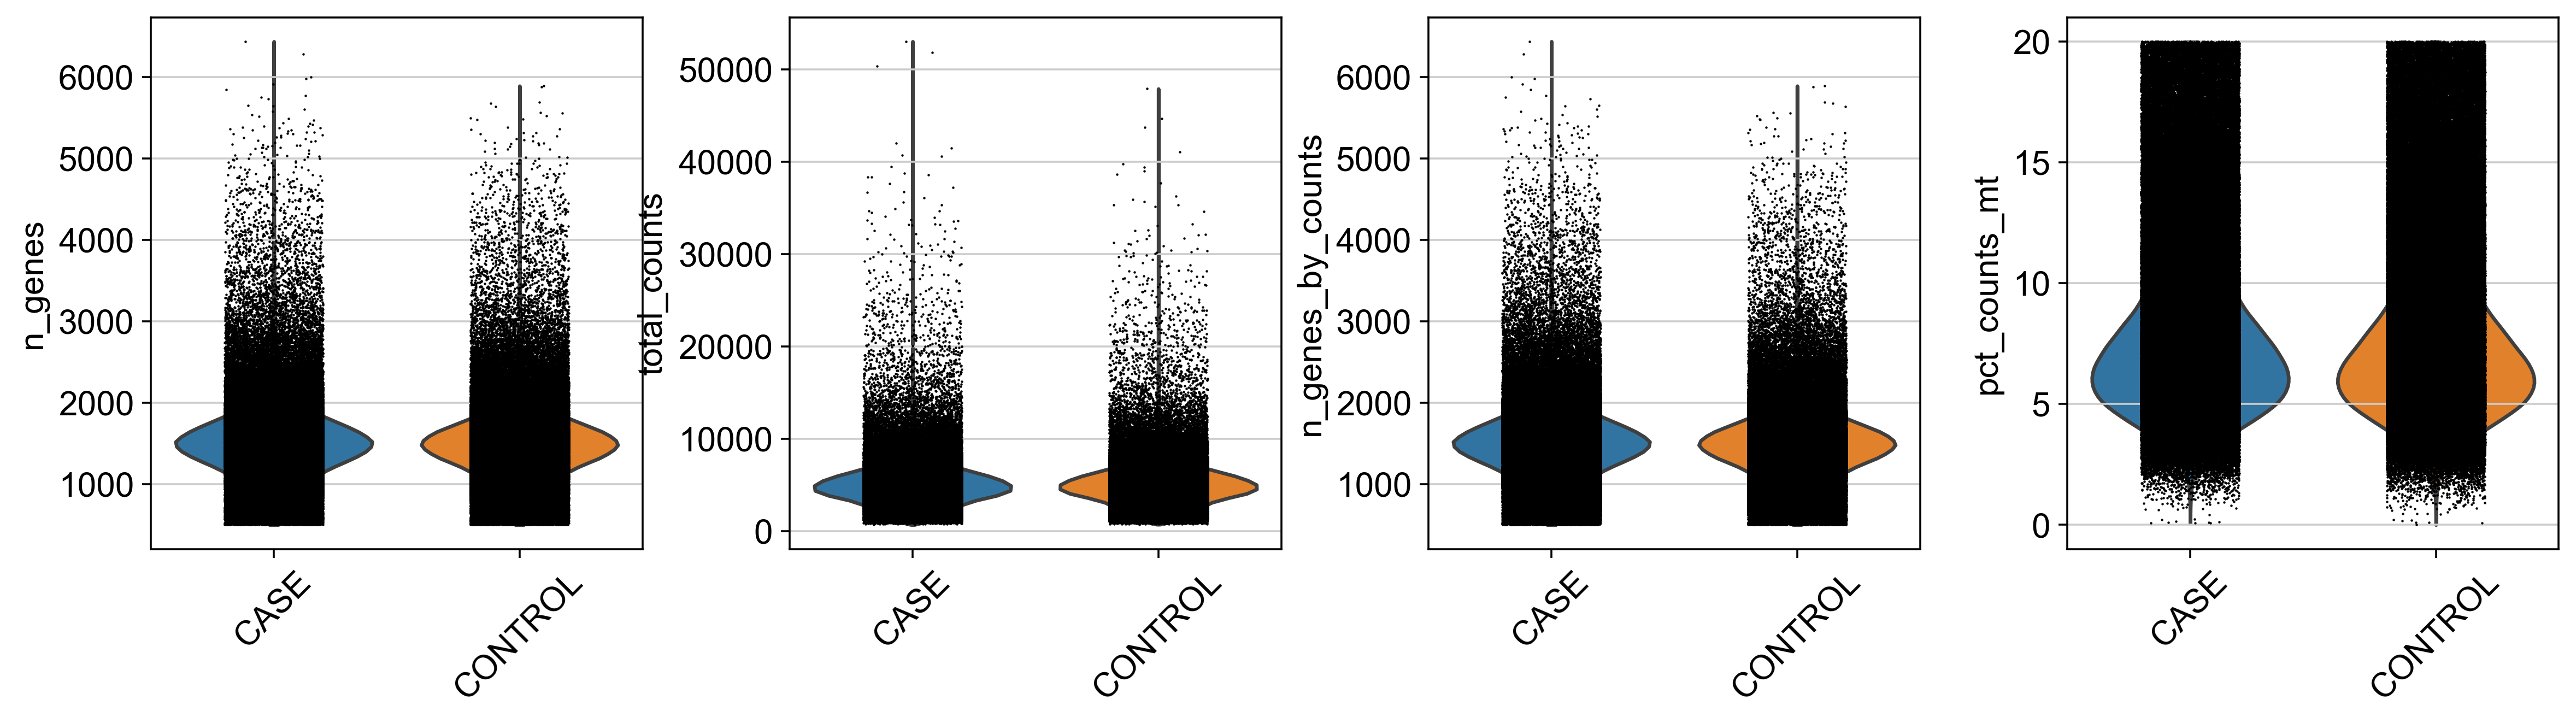

In [29]:
# Organized by disease status as sample size is too large to do by sample

sc.pl.violin(sample_object, ['n_genes', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter = 0.2, groupby = 'TB_status', rotation = 45)

### Add sample sex covariate

In [31]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [32]:
annot.head()

,ensembl_gene_id,start_position,end_position,chromosome_name
external_gene_name,,,,
MT-TF,ENSG00000210049,577,647,MT
MT-RNR1,ENSG00000211459,648,1601,MT
MT-TV,ENSG00000210077,1602,1670,MT
MT-RNR2,ENSG00000210082,1671,3229,MT
MT-TL1,ENSG00000209082,3230,3304,MT


- Y chrom

In [33]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['SRY', 'RPS4Y1', 'ZFY', 'ZFY-AS1', 'LINC00278', 'TGIF2LY', 'PCDH11Y',
       'TSPY2', 'LINC00280', 'TTTY1B', 'TTTY2B', 'TTTY21B', 'TTTY7', 'TTTY8B',
       'AMELY', 'TBL1Y', 'TTTY12', 'LINC00279', 'TTTY18', 'TTTY19', 'TTTY11',
       'TTTY20', 'TSPY4', 'TSPY8', 'TSPY3', 'FAM197Y5', 'TSPY1', 'TSPY10',
       'TTTY8', 'TTTY7B', 'TTTY21', 'TTTY2', 'TTTY1', 'TTTY22', 'TTTY23',
       'USP9Y', 'DDX3Y', 'UTY', 'TMSB4Y', 'VCY', 'VCY1B', 'NLGN4Y',
       'NLGN4Y-AS1', 'FAM41AY1', 'FAM224B', 'CDY2B', 'CDY2A', 'FAM224A',
       'FAM41AY2', 'HSFY1', 'TTTY9B', 'HSFY2', 'TTTY14', 'KDM5D', 'TTTY10',
       'EIF1AY', 'RPS4Y2', 'PRORY', 'RBMY1B', 'RBMY1A1', 'TTTY13', 'RBMY1D',
       'RBMY1E', 'PRY2', 'TTTY6B', 'RBMY1F', 'TTTY5', 'RBMY1J', 'TTTY6', 'PRY',
       'TTTY17A', 'TTTY4', 'BPY2', 'DAZ1', 'DAZ2', 'TTTY3B', 'CDY1B',
       'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ3', 'DAZ4', 'BPY2C', 'TTTY4C',
       'TTTY17C', 'CDY1', 'TTTY3'],
      dtype='object')

In [34]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1 * 100

- X chrom

In [ ]:
chrX_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "XIST"])
chrX_genes

In [35]:
sample_object.obs["XIST-counts"] = sample_object.X[:,sample_object.var_names.str.match('XIST')].toarray()

In [ ]:
sc.set_figure_params(figsize=(25, 7),dpi=100)
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'donor', rotation = 45)

### Calculate cell cycle scores

In [36]:
!if [ ! -f /Users/mairi.mcclean/cell_cycle_gene.txt ]; then curl -o /Users/mairi.mcclean/cell_cycle_gene.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [37]:
cell_cycle_genes = [x.strip() for x in open('/Users/mairi.mcclean/data/qc_files/cell_cycle_gene.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [ ]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

In [ ]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'TB_status', rotation = 45)

In [ ]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

### Predict doublets

In [ ]:
holder = np.zeros((sample_object.shape[0],))
for smp in np.unique(sample_object.obs['batch']):
    if smp == []:
        continue
    adata_smp = sample_object[sample_object.obs['batch'] == smp]
    scrub = scr.Scrublet(adata_smp.X)
    adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
    holder[sample_object.obs['batch'] == smp] = adata_smp.obs['predicted_doublets']
sample_object.obs['predicted_doublets'] = holder

sum(sample_object.obs['predicted_doublets'])
sample_object

In [ ]:
scrub.plot_histogram()

In [ ]:
#check if our predicted doublets also have more detected genes in general; what would be the number required to raise suspicions?

sc.pl.violin(sample_object, ['n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'predicted_doublets'],
             jitter = 0.2, groupby = 'TB_status', rotation = 45)

### Prepare counts for individual slots

In [ ]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

### Export object

In [ ]:
sample_object.write('/Volumes/LaCie/data_lake/Mairi_example/processed_files/abridged_qc/human/Nathan2021_citeseq_PBMC_mm_230306_qcd.h5ad')
